# The Battle of the Neighborhoods

## Introduction 
The objective is to locate and recommend to the client which neighbourhood in New York City will be best choice to start a restaurant.



## What can be answered using above dataset
- What is best location in New York City for Japanese Restaurant ?
- Which areas have potential Japanese Resturant Market ?
- Which all areas lack Japanese Resturants ?
- Which is the best place to stay if I prefer Japanese Cuisine ?

## Approach
- Collect the new york city data from https://cocl.us/new_york_dataset
- Using FourSquare API we will find all venues for each neighborhood.
- Filter out all venues that are Japanese Resturants.
- Find rating , tips and like count for each Japanese Resturants using FourSquare API.
- Using rating for each resturant , we will sort that data.
- Visualize the Ranking of neighborhoods using folium library(python)

import the library


In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

**Using FourSquare API we will find all venues for each neighborhood**

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

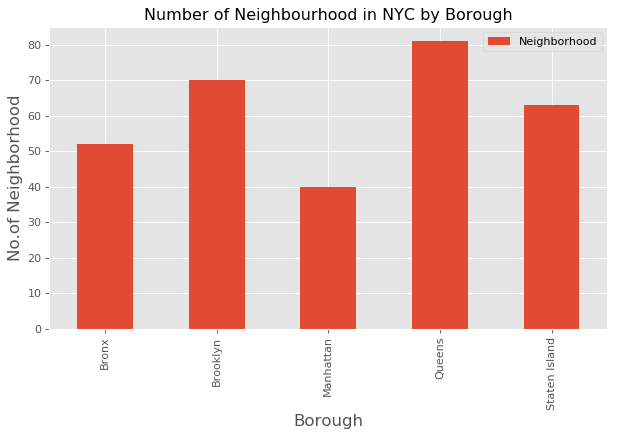

In [9]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

**prepare neighborhood list that contains japanese restaurant**

In [35]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
jap_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    jap_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(jap_resturants)))
    for resturant_detail in jap_resturants.values.tolist():
        id, name , category=resturant_detail
        jap_rest_ny = jap_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:2
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:2
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:1
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

( 138 / 306 ) Japanese Resturants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Resturants in Flushing, Queens:2
( 140 / 306 ) Japanese Resturants in Long Island City, Queens:1
( 141 / 306 ) Japanese Resturants in Sunnyside, Queens:0
( 142 / 306 ) Japanese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Resturants in Maspeth, Queens:1
( 144 / 306 ) Japanese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Resturants in Glendale, Queens:1
( 146 / 306 ) Japanese Resturants in Rego Park, Queens:1
( 147 / 306 ) Japanese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Resturants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Resturants in College Point, Queens:1
( 151 / 306 ) Japanese Resturants in Whitestone, Queens:2
( 152 / 306 ) Japanese Resturants in Bayside, Queens:0
( 153 / 306 ) Japanese Resturants in Auburndale, Queens:1
( 154 / 306 ) Japanese Resturants in Little Neck, Queens:1
( 155 

( 271 / 306 ) Japanese Resturants in Mount Hope, Bronx:0
( 272 / 306 ) Japanese Resturants in Sutton Place, Manhattan:0
( 273 / 306 ) Japanese Resturants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Resturants in Turtle Bay, Manhattan:2
( 275 / 306 ) Japanese Resturants in Tudor City, Manhattan:3
( 276 / 306 ) Japanese Resturants in Stuyvesant Town, Manhattan:1
( 277 / 306 ) Japanese Resturants in Flatiron, Manhattan:3
( 278 / 306 ) Japanese Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) Japanese Resturants in Blissville, Queens:0
( 280 / 306 ) Japanese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Japanese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Japanese Resturants in Dumbo, Brooklyn:1
( 285 / 306 ) Japanese Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Japanese Resturants in Willowbrook, Staten Island:0
( 287 / 3

In [43]:
jap_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


In [38]:
jap_rest_ny.shape


(174, 4)

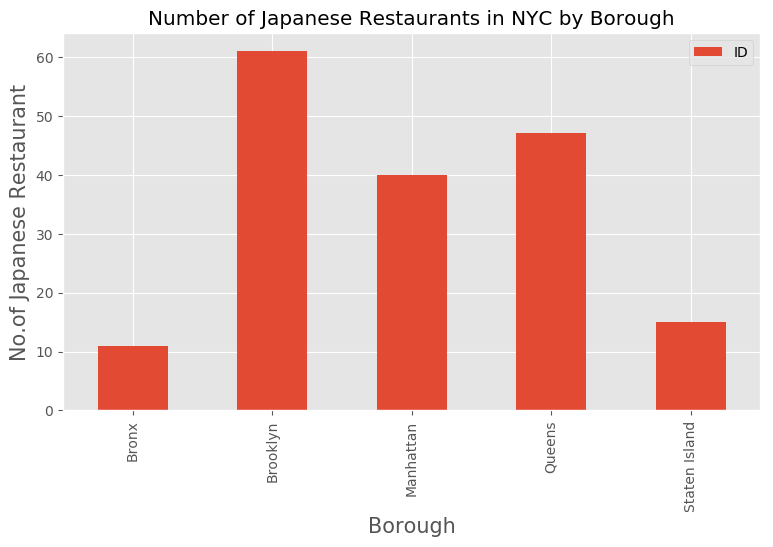

In [39]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Restaurant', fontsize=15)
#giving a bar plot
jap_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [42]:
# prepare neighborhood list that contains jap resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
jap_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in jap_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains jap resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
jap_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in jap_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(jap_rest_ny),')','processed')
    jap_rest_stats_ny = jap_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

No data available for id= 503cfaffe4b066d39de5005a
( 1 / 174 ) processed
No data available for id= 4b0b311af964a520642e23e3
( 2 / 174 ) processed
No data available for id= 503cfaffe4b066d39de5005a
( 3 / 174 ) processed
No data available for id= 4b0b311af964a520642e23e3
( 4 / 174 ) processed
No data available for id= 4dbdf3d790a02849cbd675be
( 5 / 174 ) processed
No data available for id= 5d40d7a398a00a0008b4c8ca
( 6 / 174 ) processed
No data available for id= 5c79cb8360255e002c86ffaf
( 7 / 174 ) processed
No data available for id= 503cfaffe4b066d39de5005a
( 8 / 174 ) processed
No data available for id= 4b0b311af964a520642e23e3
( 9 / 174 ) processed
No data available for id= 54e0efc3498e7eda5dff1847
( 10 / 174 ) processed
No data available for id= 54de4db5498ee465b7d151d2
( 11 / 174 ) processed
No data available for id= 4b33fd94f964a520842325e3
( 12 / 174 ) processed
No data available for id= 51f42bb3498e2681264e00a1
( 13 / 174 ) processed
No data available for id= 513e7ec8e4b07f4fa1b53

No data available for id= 5cf07afa66f3cd002c8b3ae6
( 112 / 174 ) processed
No data available for id= 5501cbe6498e4f463c238485
( 113 / 174 ) processed
No data available for id= 4b6f3283f964a520ace32ce3
( 114 / 174 ) processed
No data available for id= 54e52f13498e7116ea0cb0d0
( 115 / 174 ) processed
No data available for id= 5a22f5b8d41bb773bfc3f5c3
( 116 / 174 ) processed
No data available for id= 4b9ae1e3f964a52030df35e3
( 117 / 174 ) processed
No data available for id= 4ee7eaf7469064168cac36bf
( 118 / 174 ) processed
No data available for id= 4c3b4ae416cb2d7f8b9c02a9
( 119 / 174 ) processed
No data available for id= 4b5b135df964a52057e228e3
( 120 / 174 ) processed
No data available for id= 4bba1c4b1261d13a243cea98
( 121 / 174 ) processed
No data available for id= 4fbfb2ece4b0a6eab8ea41b8
( 122 / 174 ) processed
No data available for id= 45da8cc4f964a520f8421fe3
( 123 / 174 ) processed
No data available for id= 4bca626368f976b086615f83
( 124 / 174 ) processed
No data available for id=

In [44]:
jap_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,0,0,0,0,0
1,Bronx,Riverdale,0,0,0,0,0
2,Bronx,Kingsbridge,0,0,0,0,0
3,Bronx,Kingsbridge,0,0,0,0,0
4,Bronx,City Island,0,0,0,0,0
